# Conglomerate RADAR data of picked bed from radargrams


- Huw put .txt files in /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_*.txt
- The DELAY column is time. 
- This Converts DELAY to depth.
- saves all data at /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp

NB Look at the .jcs file to map from the SEQnum (the * in the file name) to other names.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon
import fiona

In [2]:
paths = glob.glob('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_*.txt')
paths

['/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_33.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_22.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_41.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_17.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_10.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_39.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_3.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_18.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_1.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_16.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_38.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_14.txt',
 '/Volumes/arc_04/

### The Data, ie the picked beds look like:

In [3]:
!head {paths[0]}

CDP SOURCE_X SOURCE_Y DELAY ELEVATION YEAR DAY HOUR MINUTE SECOND
100 -37481120 -73102700 6220 2916.31 2019 358 2 6 1100
101 -37481180 -73102530 6220 2915.78 2019 358 2 6 1204
102 -37481260 -73102240 6220 2914.42 2019 358 2 6 1402
103 -37481370 -73101860 6220 2914.89 2019 358 2 6 1601
104 -37481420 -73101690 6220 2913.32 2019 358 2 6 1696
105 -37481530 -73101310 6220 2920.22 2019 358 2 6 1904
106 -37481590 -73101100 6220 2923.47 2019 358 2 6 1999
107 -37481710 -73100680 6220 2916.59 2019 358 2 6 2197
108 -37481760 -73100480 6220 2911.72 2019 358 2 6 2301


In [4]:
!head /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_1.txt

CDP SOURCE_X SOURCE_Y DELAY ELEVATION YEAR DAY HOUR MINUTE SECOND
100 -38212230 -72655980 8780 7123.05 2019 361 21 52 100
101 -38212090 -72655770 8780 7123.08 2019 361 21 52 298
102 -38211850 -72655460 8780 7123.15 2019 361 21 52 497
103 -38211690 -72655270 8780 7123.21 2019 361 21 52 601
104 -38211530 -72655090 8780 7123.27 2019 361 21 52 704
105 -38211250 -72654730 8780 7123.41 2019 361 21 52 903
106 -38211090 -72654550 8780 7123.49 2019 361 21 52 998
107 -38210920 -72654350 8780 7123.58 2019 361 21 52 1102
108 -38210790 -72654180 8780 7123.65 2019 361 21 52 1197


## Huws indexing SEQnum is different to arrans, Name. 
## get from one to the other other usind this picked_bed_metadata

In [5]:
 !head /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/picked_bed_metadata.csv

SEQnum Name           FirstSP  LastSP   NTraces  NTraces2 NPlot    Static   MinOffset MaxOffset Inc    Site   Dir    
 1      line7                            1743     1255     628      1250     0         376126    300           LTOR
 2      line9                            2167     1540     770      1250     0         461583    300           LTOR
 3      line0                            1785     1378     689      1250     0         413181    300           LTOR
 4      line10                           2582     1577     788      1250     0         472866    300           LTOR
 5      line11                           2456     1638     819      1250     0         491087    300           LTOR
 6      line12                           2176     1538     769      1250     0         461119    300           LTOR
 7      line13                           2337     1579     790      1250     0         473550    300           LTOR
 8      line14                           2152     1534     767      12

In [6]:
picked_bed_metadata = pd.read_csv('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/picked_bed_metadata.csv',header=0,delim_whitespace=True,index_col=0)
picked_bed_metadata.head()

,Name,FirstSP,LastSP,NTraces,NTraces2,NPlot,Static,MinOffset,MaxOffset,Inc,Site,Dir
SEQnum,,,,,,,,,,,,
1,line7,1743,1255,628,1250,0,376126,300,LTOR,NaN,NaN,NaN
2,line9,2167,1540,770,1250,0,461583,300,LTOR,NaN,NaN,NaN
3,line0,1785,1378,689,1250,0,413181,300,LTOR,NaN,NaN,NaN
4,line10,2582,1577,788,1250,0,472866,300,LTOR,NaN,NaN,NaN
5,line11,2456,1638,819,1250,0,491087,300,LTOR,NaN,NaN,NaN


In [7]:
picked_bed_metadata.iloc[1]['Name']

'line9'

# Make big dataframe of all points

In [33]:
bed_df = pd.DataFrame({},columns=['CDP','SOURCE_X','SOURCE_Y','DELAY','line_name','ELEVATION','YEAR', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])

no_data_SEQnum = []

for SEQnum in tqdm(picked_bed_metadata.index.tolist()):
    
    linename = picked_bed_metadata.loc[SEQnum]['Name']
    
    if linename in ['line0a', 'line0bKIS1']:
        continue
        
    if linename in ['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
                    'line14', 'line1', 'line2', 'line3', 'line4', 'line6', 'line7p25',
                    'line7p5', 'line7p75', 'line8', 'lineAPREScross', 'lineAPRESdown', 
                    'lineback2camp', 'linedownchan', 'lineupchan', 'left02', 'left1011',
                    'left1213', 'left1415', 'left35', 'left46', 'left79',
                    'left810', 'right1112', 'right1314', 'right13', 'right24',
                    'right68', 'right910', 'line5']:
        camp = 'KIS2'
    else:
        camp = 'KIS1'
            
    
    try:
        line_df = pd.read_csv(f'/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_{SEQnum}.txt',header=0,sep=' ')
        line_df['line_name'] = picked_bed_metadata.loc[SEQnum]['Name']
        line_df['SEQnum'] = SEQnum
        line_df['camp'] = camp
        bed_df = bed_df.append(line_df,ignore_index=True)
        del line_df
    except:
        
        print(f'SEQnum {SEQnum}, {linename} didnt work')
        no_data_SEQnum.append(SEQnum)

bed_df.rename(columns={'SOURCE_X':'x','SOURCE_Y':'y'},inplace=True)

In [34]:
# need to divide x and y by 10
bed_df.x = bed_df.x.astype('float').copy()
bed_df.y = bed_df.y.astype('float').copy()
bed_df.ELEVATION = bed_df.ELEVATION.astype('float').copy()
bed_df.SECOND = bed_df.SECOND.astype('float').copy()

bed_df.SEQnum = bed_df.SEQnum.astype('int').copy()

In [35]:
bed_df.x = bed_df.x.div(100).copy()
bed_df.y = bed_df.y.div(100).copy()
bed_df.ELEVATION = bed_df.ELEVATION.div(100).copy()
bed_df.SECOND = bed_df.SECOND.div(100).copy()

In [36]:
bed_df['DELAY'] = [int(D) for D in bed_df.DELAY.tolist()]

In [37]:
bed_df.rename(columns={'ELEVATION':'surf'},inplace=True)

In [38]:
bed_df = bed_df.astype({'YEAR': 'str','DAY': 'str','MINUTE': 'str','HOUR': 'str','SECOND':'str'}).copy()

In [39]:
bed_df.dtypes

CDP           object
x            float64
y            float64
DELAY          int64
line_name     object
surf         float64
YEAR          object
DAY           object
HOUR          object
MINUTE        object
SECOND        object
SEQnum         int64
camp          object
dtype: object

In [40]:
#pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j')
datetime = pd.to_datetime(bed_df.YEAR + bed_df.DAY + bed_df.HOUR+ bed_df.MINUTE, format ='%Y%j%H%M' ) + pd.Series( [pd.to_timedelta(f'{t} seconds') for t in bed_df.SECOND.tolist()] )

In [42]:
iso_func = lambda t : t.isoformat()

bed_df['time_UTC'] = datetime.apply(iso_func)

In [43]:
bed_df.head()

,CDP,x,y,DELAY,line_name,surf,YEAR,DAY,HOUR,MINUTE,SECOND,SEQnum,camp,time_UTC
0,100,-382122.3,-726559.8,8780,line7,71.2305,2019,361,21,52,1.0,1,KIS2,2019-12-27T21:52:01
1,101,-382120.9,-726557.7,8780,line7,71.2308,2019,361,21,52,2.98,1,KIS2,2019-12-27T21:52:02.980000
2,102,-382118.5,-726554.6,8780,line7,71.2315,2019,361,21,52,4.97,1,KIS2,2019-12-27T21:52:04.970000
3,103,-382116.9,-726552.7,8780,line7,71.2321,2019,361,21,52,6.01,1,KIS2,2019-12-27T21:52:06.010000
4,104,-382115.3,-726550.9,8780,line7,71.2327,2019,361,21,52,7.04,1,KIS2,2019-12-27T21:52:07.040000


In [44]:
bed_df.drop(columns=['YEAR','DAY','HOUR','MINUTE','SECOND'],inplace=True)

In [45]:
points = [Point(xy) for xy in zip(bed_df.x,bed_df.y)]
bed_gdf = gpd.GeoDataFrame(bed_df,geometry=points,crs="EPSG:3031")

## all lines are visible

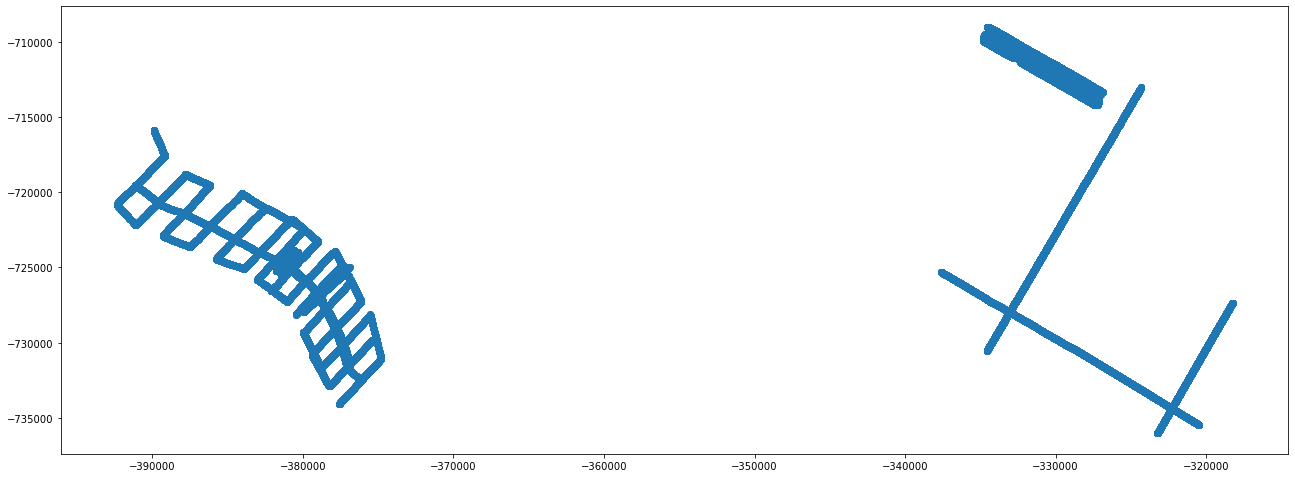

In [46]:
bed_gdf.plot(figsize=(22,14))

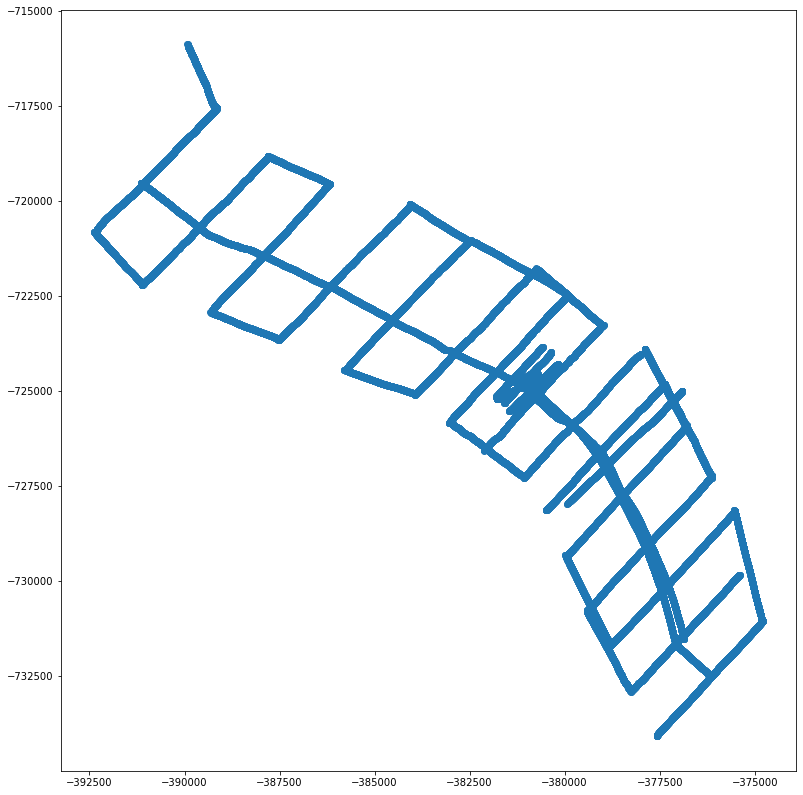

In [47]:
bed_gdf[bed_gdf.camp=='KIS2'].plot(figsize=(22,14))

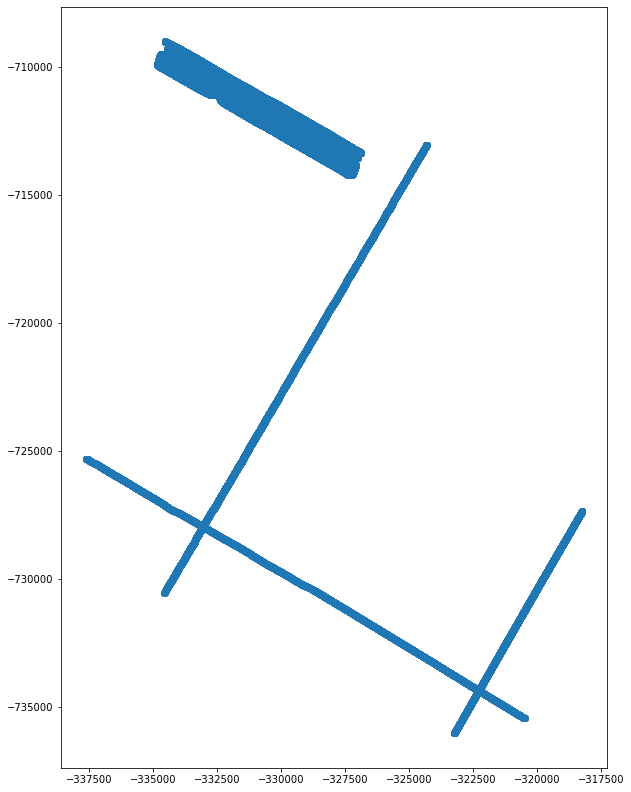

In [48]:
bed_gdf[bed_gdf.camp=='KIS1'].plot(figsize=(22,14))

In [49]:
bed_gdf.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [1]:
int(55.5)

55

# Convert DELAY to depth

follow "Investigations of the form and flow of ice sheets and glaciers using radio-echo sounding"
https://iopscience.iop.org/article/10.1088/0034-4885/67/10/R03/pdf

168 nm/s ice velocity

"+" 7 m firn correction

DELAY is two way travel time

$u  = d / t$


$ t_{firm} = thickness_{firn} velocity_{firn} $

$separationdistance^2 + depth^2 = (traveldistance/2)^2$

$depth = \sqrt{(traveldistance/2)^2 -  separationdistance^2  }$

$traveldistance = DELAY  velocity$

$depth = \sqrt{( DELAY  velocity/2)^2 -  separationdistance^2  }$


In [51]:
velocity_ice = 168e-3
velocity_firn = 400
thickness_firn = 7
separation_distance = 58.37

In [52]:
bed_gdf['ice_thickn'] = np.sqrt( (bed_gdf.DELAY.copy()*velocity_ice/2)**2 - separation_distance**2  ) + 7 

In [53]:
bed_df.drop(columns=['DELAY'],inplace=True)

In [59]:
bed_gdf['bed'] = bed_gdf.surf - bed_gdf.ice_thickn

In [60]:
bed_gdf.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [63]:
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'geometry', 'ice_thickn', 'bed'],
      dtype='object')

In [64]:
bed_gdf

,CDP,x,y,DELAY,line_name,surf,SEQnum,camp,time_UTC,geometry,ice_thickn,bed
0,100,-382122.3,-726559.8,8780,line7,71.2305,1,KIS2,2019-12-27T21:52:01,POINT (-382122.300 -726559.800),742.206565,-670.976065
1,101,-382120.9,-726557.7,8780,line7,71.2308,1,KIS2,2019-12-27T21:52:02.980000,POINT (-382120.900 -726557.700),742.206565,-670.975765
2,102,-382118.5,-726554.6,8780,line7,71.2315,1,KIS2,2019-12-27T21:52:04.970000,POINT (-382118.500 -726554.600),742.206565,-670.975065
3,103,-382116.9,-726552.7,8780,line7,71.2321,1,KIS2,2019-12-27T21:52:06.010000,POINT (-382116.900 -726552.700),742.206565,-670.974465
4,104,-382115.3,-726550.9,8780,line7,71.2327,1,KIS2,2019-12-27T21:52:07.040000,POINT (-382115.300 -726550.900),742.206565,-670.973865
...,...,...,...,...,...,...,...,...,...,...,...,...
78626,1617,-380480.6,-728123.0,8280,line5,56.8354,49,KIS2,2019-12-30T04:33:19.990000,POINT (-380480.600 -728123.000),700.066385,-643.230985
78627,1618,-380483.0,-728125.5,8280,line5,56.8668,49,KIS2,2019-12-30T04:33:21.970000,POINT (-380483.000 -728125.500),700.066385,-643.199585
78628,1619,-380485.3,-728127.9,8280,line5,56.8149,49,KIS2,2019-12-30T04:33:23.960000,POINT (-380485.300 -728127.900),700.066385,-643.251485
78629,1620,-380487.6,-728130.1,8280,line5,56.8008,49,KIS2,2019-12-30T04:33:26.030000,POINT (-380487.600 -728130.100),700.066385,-643.265585


In [62]:
bed_gdf.dtypes

CDP             object
x              float64
y              float64
DELAY            int64
line_name       object
surf           float64
SEQnum           int64
camp            object
time_UTC        object
geometry      geometry
ice_thickn     float64
bed            float64
dtype: object